# Classification of spoken digits with snnTorch

Developed by [Fredrik Sandin](https://www.ltu.se/staff/f/fresan-1.10646?l=en).

In this exercise you will learn how to load and transform an event dataset of speech and develop a spiking neural network for classification of spoken digits using snnTorch. See the related tutorials and lecture material referenced in Canvas for background information.

There are 3 ***mandatory tasks*** and 1 *optional task* in this exercise.

## 1 Import libraries
Unless you have already done so, you must first install snnTorch, Tonic, and matplotlib to run this exercise.

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import snntorch as snn

import tonic
from tonic import DiskCachedDataset
import tonic.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

## 2 Loading event data with Tonic

In this exercise you will load an event-based dataset using [Tonic](https://github.com/neuromorphs/tonic), which provides some publicly available event-based vision and audio datasets and event transformations. The package is compatible with snnTorch/PyTorch.

This exercise focuses on classifying spoken digits in the [Spiking Heidelberg Digits (SHD)](https://zenkelab.org/resources/spiking-heidelberg-datasets-shd/) dataset, which includes approximately 10000 high-quality aligned studio recordings of spoken digits from 0 to 9 in both German and English language from 12 distinct speakers, out of which two speakers are only present in the test set. Each digit is represented by spikes on 700 channels which were generated using [Lauscher](https://github.com/electronicvisions/lauscher), a neuromorphic [cochlea](https://iopscience.iop.org/article/10.1088/2634-4386/ac4a83#nceac4a83s47) software model. The SHD webpage referenced above includes a leader board and the data set is presented in the following paper.

Cramer, B., Stradmann, Y., Schemmel, J., and Zenke, F. (2022).
*The Heidelberg Spiking Data Sets for the Systematic Evaluation of Spiking Neural Networks*.
IEEE Transactions on Neural Networks and Learning Systems 33, 2744–2757.
[https://doi.org/10.1109/TNNLS.2020.3044364](https://doi.org/10.1109/TNNLS.2020.3044364).

Recent work by Boeshertz et al. (https://arxiv.org/abs/2407.13534) has show that it can be preferable to use adaptive LIF neurons to generate spikes from the original Heidelberg Digits data, both w.r.t. precision and data reduciton. For those of you who want to are ambiitons and want to expand your knowledge beyond the course content, read this paper, evaluate the proposed neuron model and hypothesize why it generates better spiking data than the alternative we load in this exercise.

### 2.1 Load the training dataset and plot samples
The SHD training set includes 8156 spoken digit samples. Each digit is represented by an array of events which consists of three parameters (timestamp t, cochlea channel number x, polarity p). Plot the spike representations of five different samples of one particular digit. What are the different channels representing? What is the time duration of the patterns? Why are the patterns different although the same digit is spoken?

***Mandatory task 1:***

Extend the code below so that it plots one digit sample for each of the 20 classes in the dataset. Thus, the subplot should have 20 panels. Each panel should illustrate one sample of one particular digit. Plot different samples and analyse the variations. Are different samples of one and the same digit similar or different? Why?

In [3]:
dataset = tonic.datasets.SHD(save_to='./shd', train=True)
sensor_size = dataset.sensor_size
print("Sensor size (# channels):", sensor_size)
print("Number of training samples:", len(dataset))
print("Event representation: ", dataset.dtype)
print("Classes:", [c.decode('UTF-8') for c in dataset.classes])

  0%|          | 0/130863613 [00:00<?, ?it/s]

Extracting ./shd\SHD\shd_train.h5.zip to ./shd\SHD
Sensor size (# channels): (700, 1, 1)
Number of training samples: 8156
Event representation:  [('t', '<i4'), ('x', '<i4'), ('p', '<i4')]
Classes: ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'null', 'eins', 'zwei', 'drei', 'vier', 'fuenf', 'sechs', 'sieben', 'acht', 'neun']


Digit 33 is represented by 5568 events
Digit 35 is represented by 8034 events
Digit 109 is represented by 5620 events
Digit 136 is represented by 5243 events
Digit 147 is represented by 6263 events


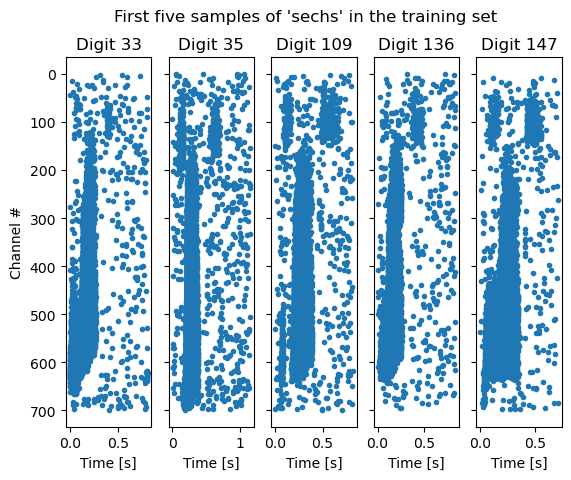

In [4]:
index = 0
samples = 0
digit = "sechs"
fig, axs = plt.subplots(1,5, sharey=True)
fig.suptitle(f"First five samples of '{digit}' in the training set")
axs[0].set_ylabel("Channel #")
while samples < len(axs):
    events, label = dataset[index]
    if dataset.classes[label].decode('UTF-8') == digit:
        axs[samples].scatter(1e-6*events['t'], events['x'], marker=".")
        axs[samples].invert_yaxis()
        axs[samples].set_title(f"Digit {index}")
        axs[samples].set_xlabel("Time [s]")
        print(f"Digit {index} is represented by {len(events)} events")
        samples += 1
    index += 1

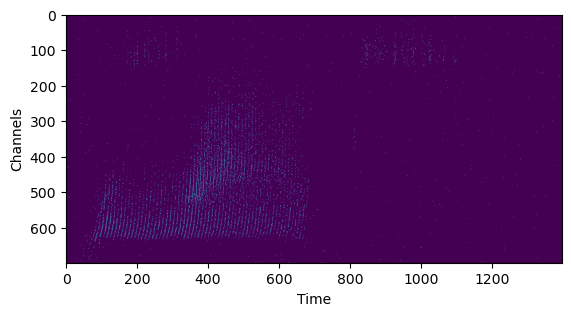

In [5]:
# Tonic provides an event plotting function that can also be used (Time in ms), which rasterizes the events and displays the result with imshow().
tonic.utils.plot_event_grid(events)

Digit 0 is represented by 4278 events
Digit 1 is represented by 12118 events
Digit 2 is represented by 4896 events
Digit 3 is represented by 10088 events
Digit 4 is represented by 10561 events
Digit 6 is represented by 7934 events
Digit 7 is represented by 7071 events
Digit 8 is represented by 6144 events
Digit 9 is represented by 5676 events
Digit 11 is represented by 8816 events
Digit 13 is represented by 12889 events
Digit 14 is represented by 7000 events
Digit 22 is represented by 5078 events
Digit 24 is represented by 6401 events
Digit 33 is represented by 5568 events
Digit 40 is represented by 6604 events
Digit 45 is represented by 4274 events
Digit 62 is represented by 12023 events
Digit 73 is represented by 8927 events
Digit 82 is represented by 9162 events


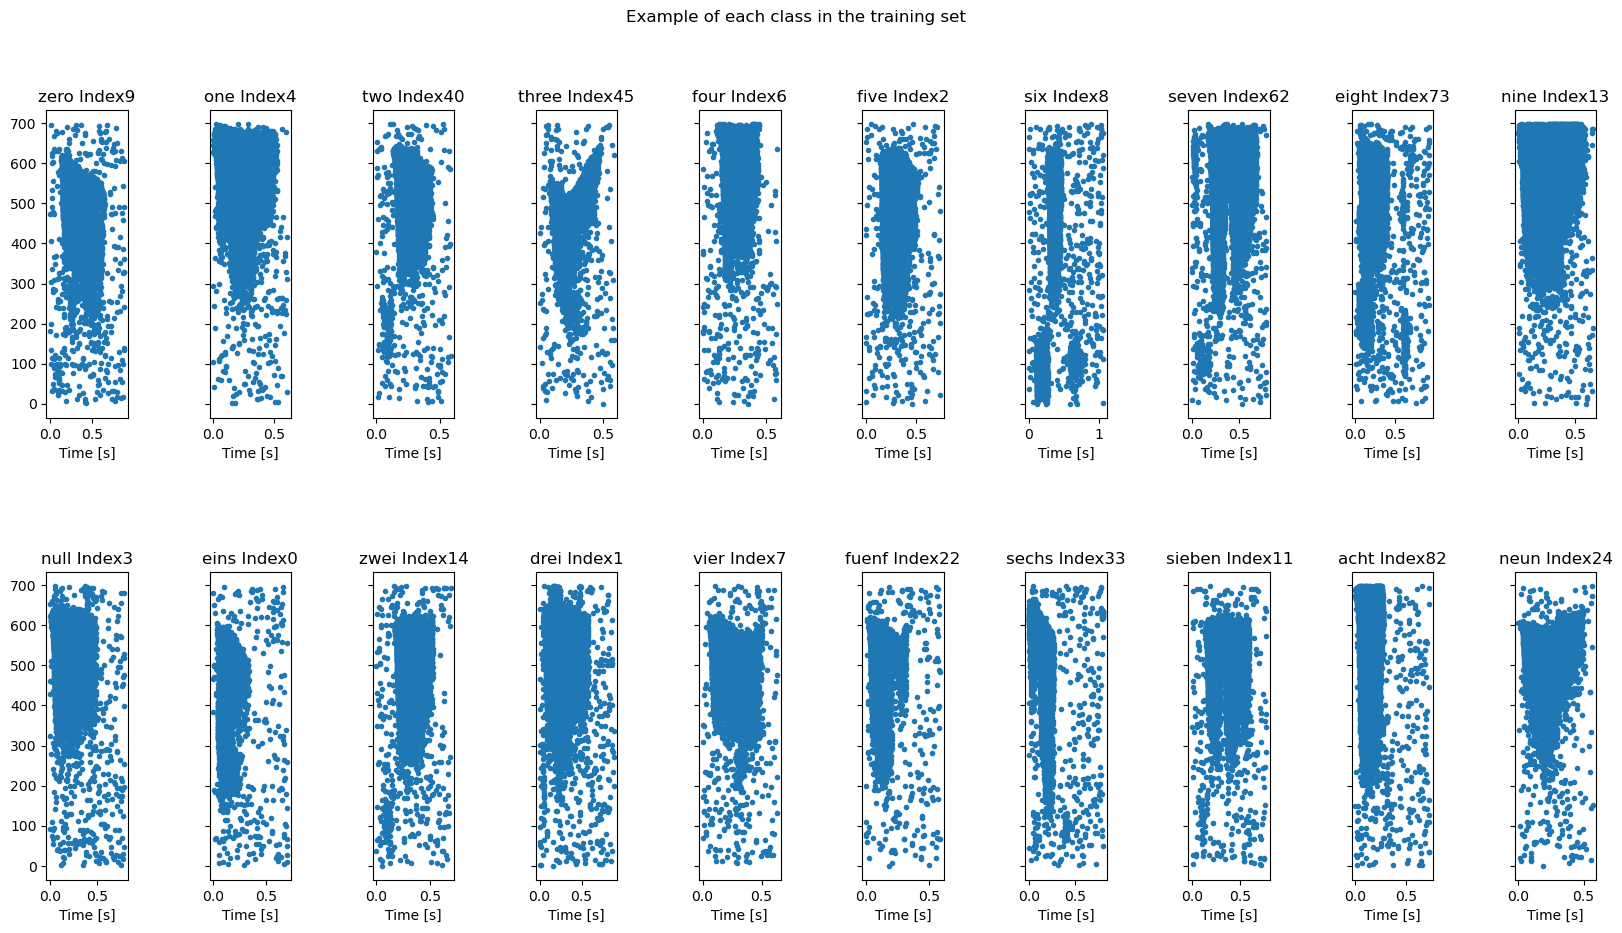

In [6]:
sample = 0
index = 0

fig, axs = plt.subplots(2,10, sharey=True, figsize=(20, 10))
fig.suptitle(f"Example of each class in the training set")
fig.subplots_adjust(wspace=1, hspace=0.5)

plotted_digit = []
while sample < 20:
  events, label = dataset[index]
  if label not in plotted_digit:
    row = label//10
    col = label%10
    axs[row, col].scatter(1e-6*events['t'], events['x'], marker=".")
    axs[row, col].invert_yaxis()
    axs[row, col].set_title(f"{dataset.classes[label].decode('UTF-8')} Index{index}")
    axs[row, col].set_xlabel("Time [s]")
    print(f"Digit {index} is represented by {len(events)} events")
    sample += 1
    plotted_digit.append(label)
  index += 1


Note: the samples from the same class have similar pattern , samples from different classes shows different pattern.

### 2.2 Downsample the digits and create a dataloader

Now you are familiar with the samples in the dataset. It is time to prepare the digits in a format that is suitable for snnTorch experiments on a PC. To obtain state-of-the-art results we would need to keep a high spatial and temporal resolution of the digits. However, with 700 input channels the simulations would take far too long time if we process the full-resolution digits.

We can choose a set of transforms to apply to our data before feeding it to an SNN. Here we [Downsample](https://tonic.readthedocs.io/en/main/autoapi/tonic/transforms/index.html#tonic.transforms.Downsample) the events to 70 channels instead of 700, which reduces the dimension of the resulting tensor representations. Furthermore, we use the [toFrame](https://tonic.readthedocs.io/en/main/generated/tonic.transforms.ToFrame.html#tonic.transforms.ToFrame) transformation with time-binning over 10000 microseconds, which results in a sequence of 10-millisecond long frames with 70 channels each.

To speed up dataloading, we can make use of disk caching and batching. That means that once the files are loaded from the original dataset they are written to the disk. Because the event arrays have different lengths, we are going to use a collation function tonic.collation.PadTensors() that will pad shorter recordings to ensure all tensors in a batch have the same dimensions.

If you need to refresh basic machine learning concepts such as "batch" and "training set" a good reference is the [Deep Learning](https://www.deeplearningbook.org/) book, which is part of the course literature in the [D7046E Neural networks and learning machines](https://www.ltu.se/edu/course/D70/D7046E/D7046E-Neuronnat-och-larande-maskiner-1.183276?kursView=kursplan&l=en) course.

In [7]:
batch_size = 16 # Keeping this small for clarity of the examples below, you may need to increase it later

# OBS: You must first delete the cache files before running this with new parameters/transforms, otherwise there is no effect of modified hyperparameters

trainset = tonic.datasets.SHD(
    save_to='./data',
    train=True,
    transform=transforms.Compose([
        transforms.Downsample(sensor_size=sensor_size, spatial_factor=0.1), # 70 channels
        transforms.ToFrame(sensor_size=(70,1,1),time_window=10000) # us to 10 ms
    ])
)

cached_trainset = DiskCachedDataset(
    trainset,
    cache_path='./data/cache/shd/train',
    transform=torch.from_numpy
)

trainloader = DataLoader(
    cached_trainset,
    batch_size=batch_size,
    collate_fn=tonic.collation.PadTensors()
)

trainiter = iter(trainloader)

# Function that returns the next batch from the training set
def load_training_batch():
    events, targets = next(trainiter)
    # snnTorch torch uses time-first tensors, which means [time x batch_size x feature_dimensions].
    # Convert from the default [batch_size x time x 1 x channels] frame representation in the dataset:
    events = events.transpose(0,1).squeeze()
    return (events, targets)

  0%|          | 0/130863613 [00:00<?, ?it/s]

Extracting ./data\SHD\shd_train.h5.zip to ./data\SHD


### 2.3 Load one batch and visualize the downsampled digits

Shape of batch with 16 digits:  torch.Size([105, 16, 70])


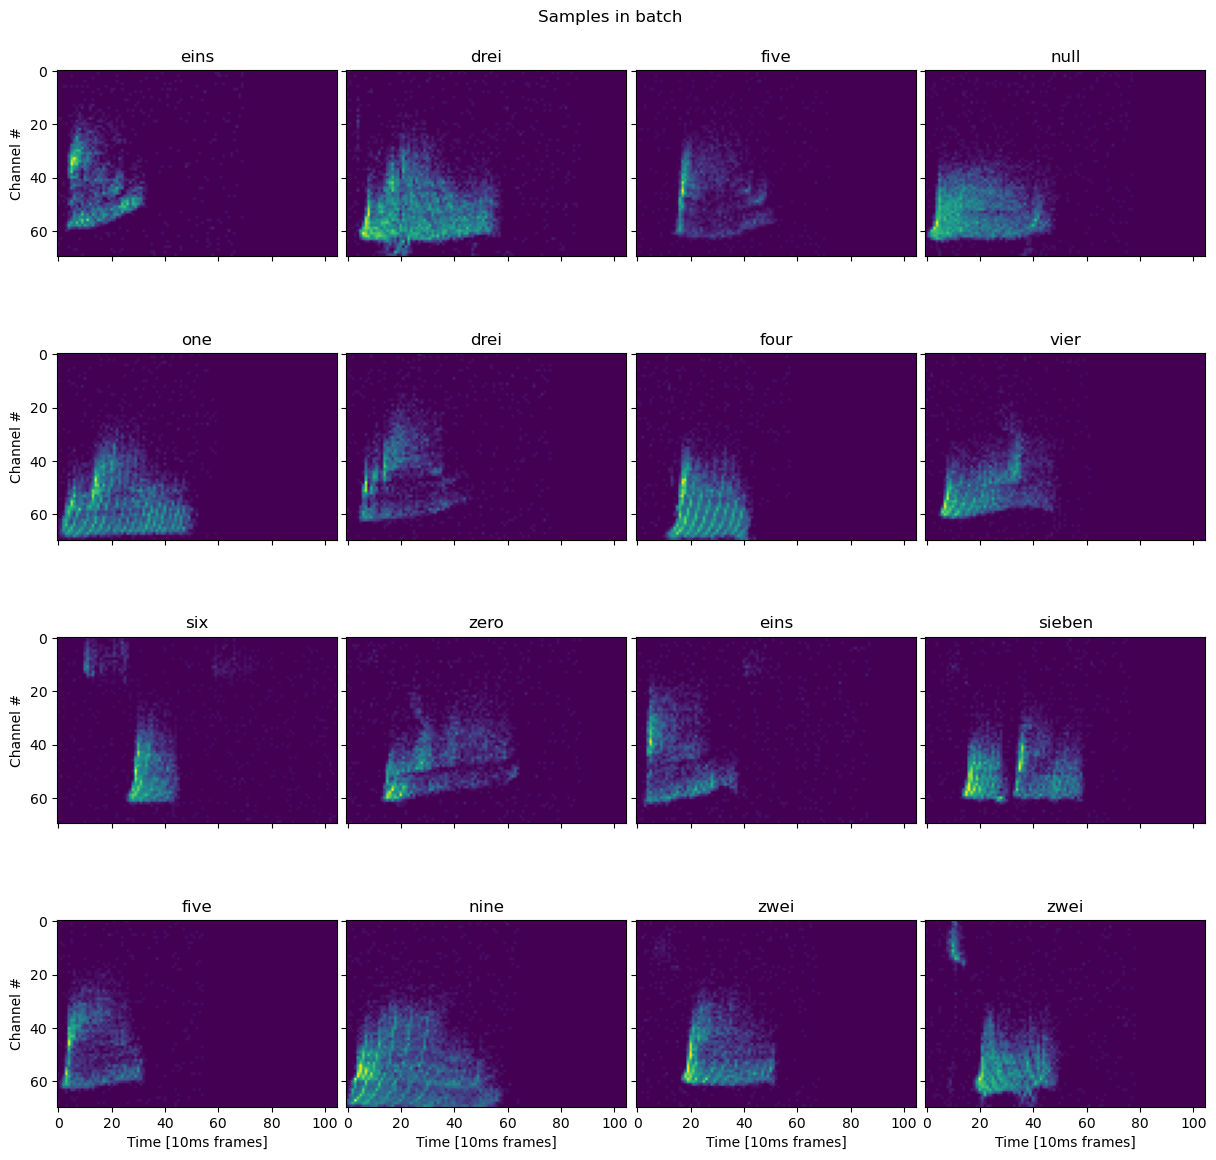

In [8]:
# Enable plotting of tensors with matplotlib
torch.Tensor.ndim = property(lambda self: len(self.shape))

events, target = load_training_batch()
print(f"Shape of batch with {batch_size} digits: ", events.shape)

fig,axs = plt.subplots(4,4,figsize=(12,12),sharex=True, sharey=True)
fig.suptitle(f"Samples in batch")

for i in range(4):
    axs[i,0].set_ylabel('Channel #')
    for j in range(4):
        index = i*4+j
        tensor = events[:,index,:].transpose(0,1)
        axs[i,j].imshow(tensor)
        axs[i,j].set_title(trainset.classes[target[index]].decode('UTF-8'))
        if i==3:
            axs[i,j].set_xlabel('Time [10ms frames]')
plt.tight_layout(pad=0)
plt.show()

## 3 Processing of digits with a feed-forward SNN

The following is an adaptation of the feed-forward SNN example presented in the snnTorch [tutorial 3](https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_3.html). The following code implements a feed-forward SNN that processes the downsampled digits in the SHD trainset visualized above. The code illustrates the principle of how to
   * Run a basic SNN simulation with SHD input data
   * Visualize the resulting spikes in the hidden and output layer

### 3.1 Run SNN simulation over timesteps in the batch

***Mandatory task 2:*** How much longer is the simulation time of one forward pass if the original number of channels (700) in the dataset is used? Does the time-binning introduced by the toFrame transformation reduce simulation time? Run simulations to validate your analysis.

 torch.Size([105, 16, 70]) timestep x batchsize x feature dimension

 network: 70, 140, 20

 beta is decay rate

In [9]:
%%time
num_timesteps = events.shape[0]     # Number of timesteps in the longest-duration digit
num_samples = events.shape[1]       # Number of digits in batch
num_channels = events.shape[2]      # Number of channels in downsampled digits
num_classes = len(trainset.classes)

# SNN hyperparameters
beta = 0.95
num_inputs = num_channels
num_outputs = num_classes
hidden_sizefac = 2        # Size of hidden layer in relation to size of input layer

# Define first hidden layer and input connections
fc1 = nn.Linear(num_inputs, hidden_sizefac*num_channels)
lif1 = snn.Leaky(beta=beta)

# Define output layer with inputs from hidden layer
fc2 = nn.Linear(hidden_sizefac*num_channels, num_outputs)
lif2 = snn.Leaky(beta=beta)

# Initialize neuron states
mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

# Placeholders for outputs
mem2_rec = []
spk1_rec = []
spk2_rec = []

# Run network simulation over all timesteps in the input tensor
for step in range(num_timesteps):

    cur1 = fc1(events[step,:,:])  # post-synaptic current to hidden <-- spk_in x weight
    spk1, mem1 = lif1(cur1, mem1) # mem1[t+1] <--post-syn current contrib + decayed membrane
    cur2 = fc2(spk1)              # post-synaptic current to output neurons
    spk2, mem2 = lif2(cur2, mem2) # output

    # Store states for analysis and plotting
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)
    mem2_rec.append(mem2)

# Convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

print("Hidden spikes shape", spk1_rec.shape)
print("Output spikes shape", spk2_rec.shape)
print("Output potential shape:", mem2_rec.shape)

Hidden spikes shape torch.Size([105, 16, 140])
Output spikes shape torch.Size([105, 16, 20])
Output potential shape: torch.Size([105, 16, 20])
CPU times: total: 15.6 ms
Wall time: 288 ms


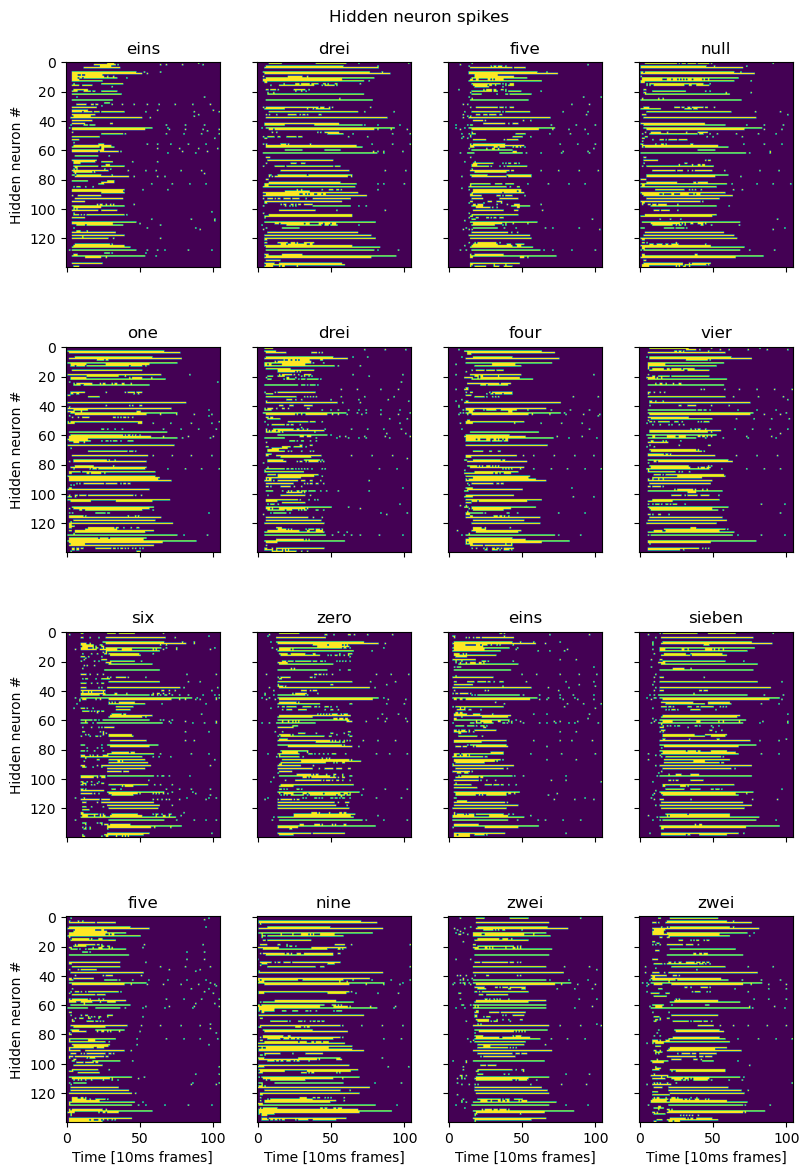

In [10]:
# Plot activity of hidden neurons for each input digit in the batch
s = spk1_rec.detach().numpy()
fig,axs = plt.subplots(4,4,figsize=(8,12),sharex=True,sharey=True)
fig.suptitle(f"Hidden neuron spikes")
fig.tight_layout()
for i in range(4):
    axs[i,0].set_ylabel('Hidden neuron #')
    for j in range(4):
        index = i*4+j
        tensor = s[:,index,:].squeeze().transpose(1,0)
        axs[i,j].imshow(tensor)
        axs[i,j].set_title(trainset.classes[target[index]].decode('UTF-8'))
        if i==3:
            axs[i,j].set_xlabel('Time [10ms frames]')
plt.show()

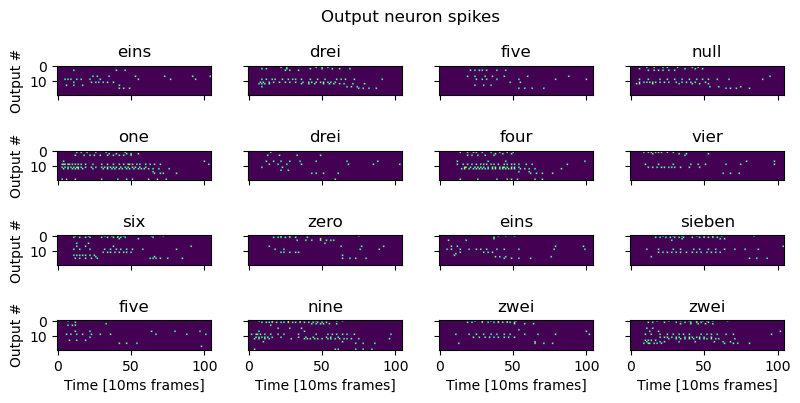

In [11]:
# Plot activity of output neurons for each input digit in the batch
s = spk2_rec.detach().numpy()
fig,axs = plt.subplots(4,4,figsize=(8,4),sharex=True,sharey=True)
fig.suptitle(f"Output neuron spikes")
fig.tight_layout()
for i in range(4):
    axs[i,0].set_ylabel('Output #')
    for j in range(4):
        index = i*4+j
        tensor = s[:,index,:].squeeze().transpose(1,0)
        axs[i,j].imshow(tensor)
        axs[i,j].set_title(trainset.classes[target[index]].decode('UTF-8'))
        if i==3:
            axs[i,j].set_xlabel('Time [10ms frames]')
plt.show()

# 700 channels

In [12]:
batch_size = 16 # Keeping this small for clarity of the examples below, you may need to increase it later

# OBS: You must first delete the cache files before running this with new parameters/transforms, otherwise there is no effect of modified hyperparameters


trainset = tonic.datasets.SHD(
    save_to='./data',
    train=True,
    transform=transforms.Compose([
        # transforms.Downsample(sensor_size=sensor_size, spatial_factor=0.1), # 70 channels
        transforms.ToFrame(sensor_size=(700,1,1),time_window=10000) # us to 10 ms
    ])
)

cached_trainset = DiskCachedDataset(
    trainset,
    cache_path='./data/cache/shd/train',
    transform=torch.from_numpy
)

trainloader = DataLoader(
    cached_trainset,
    batch_size=batch_size,
    collate_fn=tonic.collation.PadTensors()
)

trainiter = iter(trainloader)

# Function that returns the next batch from the training set
def load_training_batch():
    events, targets = next(trainiter)
    # snnTorch torch uses time-first tensors, which means [time x batch_size x feature_dimensions].
    # Convert from the default [batch_size x time x 1 x channels] frame representation in the dataset:
    events = events.transpose(0,1).squeeze()
    return (events, targets)

torch.Tensor.ndim = property(lambda self: len(self.shape))

events, target = load_training_batch()

Shape of batch with 16 digits:  torch.Size([105, 16, 700])


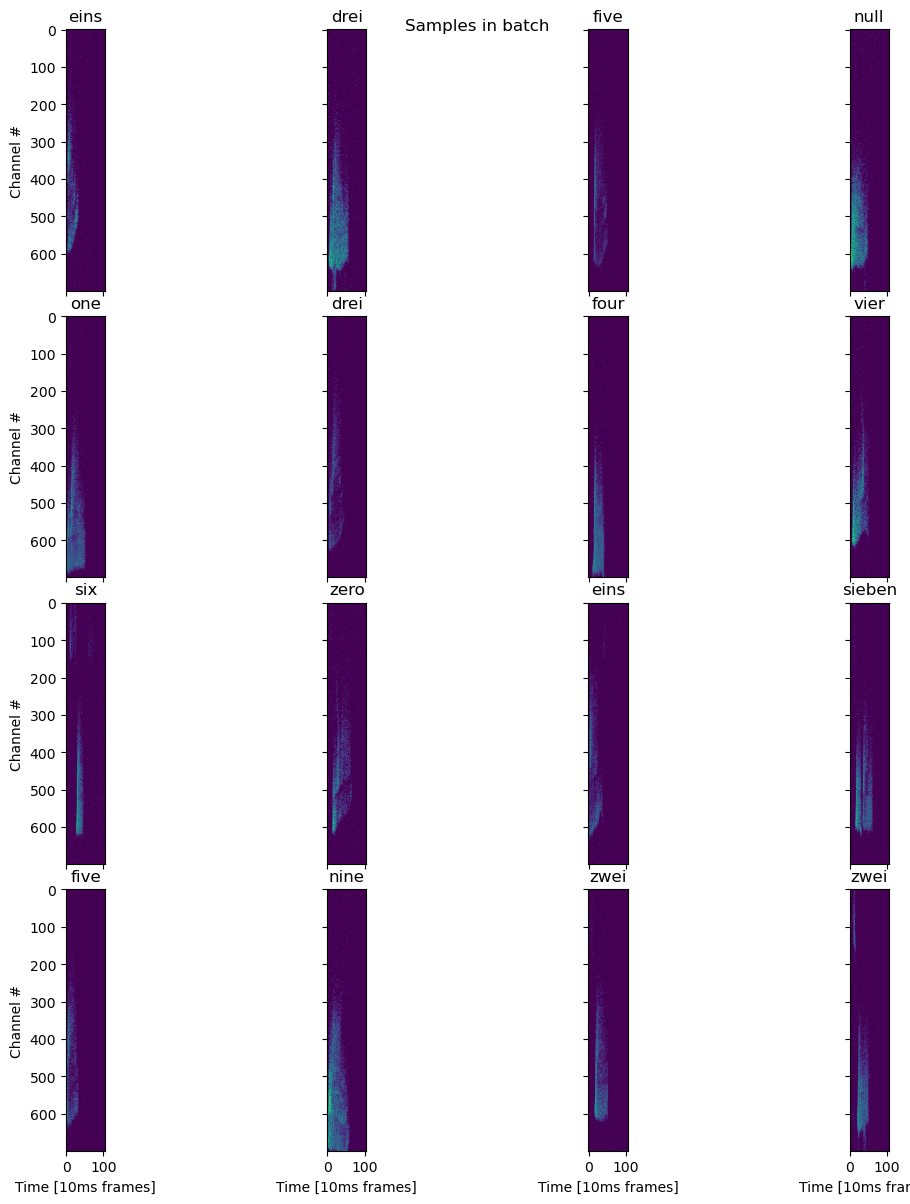

In [13]:
print(f"Shape of batch with {batch_size} digits: ", events.shape)

fig,axs = plt.subplots(4,4,figsize=(12,12),sharex=True, sharey=True)
fig.suptitle(f"Samples in batch")

for i in range(4):
    axs[i,0].set_ylabel('Channel #')
    for j in range(4):
        index = i*4+j
        tensor = events[:,index,:].transpose(0,1)
        axs[i,j].imshow(tensor)
        axs[i,j].set_title(trainset.classes[target[index]].decode('UTF-8'))
        if i==3:
            axs[i,j].set_xlabel('Time [10ms frames]')
plt.tight_layout(pad=0)
plt.show()

In [14]:
%%time
num_timesteps = events.shape[0]     # Number of timesteps in the longest-duration digit
num_samples = events.shape[1]       # Number of digits in batch
num_channels = events.shape[2]      # Number of channels in downsampled digits
num_classes = len(trainset.classes)

# SNN hyperparameters
beta = 0.95
num_inputs = num_channels
num_outputs = num_classes
hidden_sizefac = 2        # Size of hidden layer in relation to size of input layer

# Define first hidden layer and input connections
fc1 = nn.Linear(num_inputs, hidden_sizefac*num_channels)
lif1 = snn.Leaky(beta=beta)

# Define output layer with inputs from hidden layer
fc2 = nn.Linear(hidden_sizefac*num_channels, num_outputs)
lif2 = snn.Leaky(beta=beta)

# Initialize neuron states
mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

# Placeholders for outputs
mem2_rec = []
spk1_rec = []
spk2_rec = []

# Run network simulation over all timesteps in the input tensor
for step in range(num_timesteps):

    cur1 = fc1(events[step,:,:])  # post-synaptic current to hidden <-- spk_in x weight
    spk1, mem1 = lif1(cur1, mem1) # mem1[t+1] <--post-syn current contrib + decayed membrane
    cur2 = fc2(spk1)              # post-synaptic current to output neurons
    spk2, mem2 = lif2(cur2, mem2) # output

    # Store states for analysis and plotting
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)
    mem2_rec.append(mem2)

# Convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

print("Hidden spikes shape", spk1_rec.shape)
print("Output spikes shape", spk2_rec.shape)
print("Output potential shape:", mem2_rec.shape)

Hidden spikes shape torch.Size([105, 16, 1400])
Output spikes shape torch.Size([105, 16, 20])
Output potential shape: torch.Size([105, 16, 20])
CPU times: total: 203 ms
Wall time: 291 ms


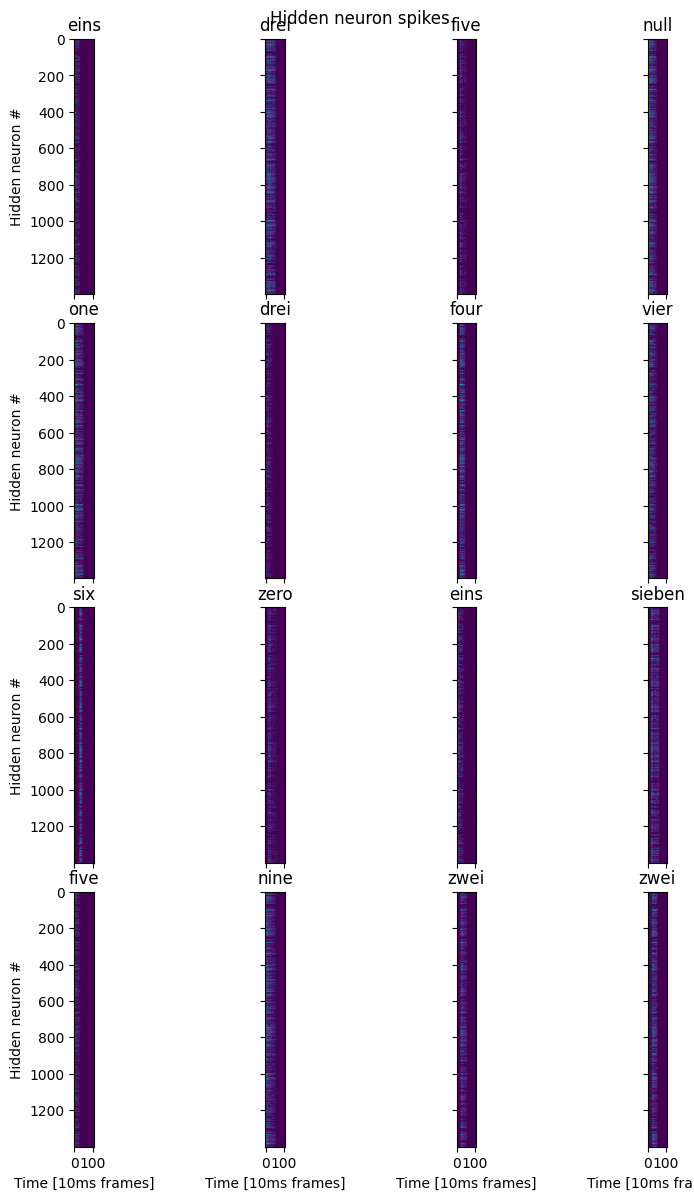

In [ ]:
# Plot activity of hidden neurons for each input digit in the batch
s = spk1_rec.detach().numpy()
fig,axs = plt.subplots(4,4,figsize=(8,12),sharex=True,sharey=True)
fig.suptitle(f"Hidden neuron spikes")
fig.tight_layout()
for i in range(4):
    axs[i,0].set_ylabel('Hidden neuron #')
    for j in range(4):
        index = i*4+j
        tensor = s[:,index,:].squeeze().transpose(1,0)
        axs[i,j].imshow(tensor)
        axs[i,j].set_title(trainset.classes[target[index]].decode('UTF-8'))
        if i==3:
            axs[i,j].set_xlabel('Time [10ms frames]')
plt.show()

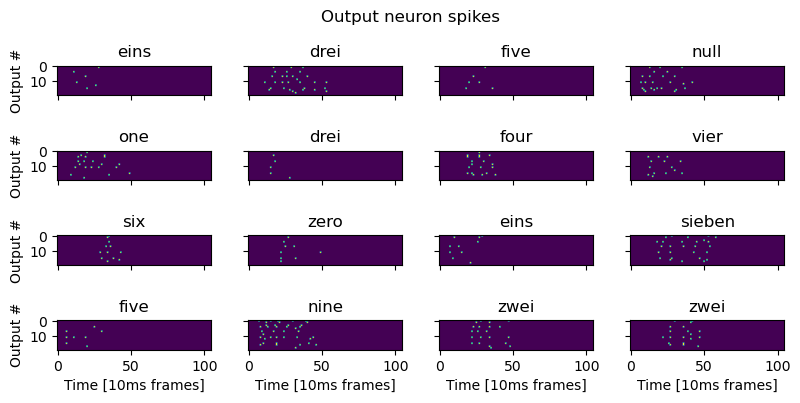

In [15]:
# Plot activity of output neurons for each input digit in the batch
s = spk2_rec.detach().numpy()
fig,axs = plt.subplots(4,4,figsize=(8,4),sharex=True,sharey=True)
fig.suptitle(f"Output neuron spikes")
fig.tight_layout()
for i in range(4):
    axs[i,0].set_ylabel('Output #')
    for j in range(4):
        index = i*4+j
        tensor = s[:,index,:].squeeze().transpose(1,0)
        axs[i,j].imshow(tensor)
        axs[i,j].set_title(trainset.classes[target[index]].decode('UTF-8'))
        if i==3:
            axs[i,j].set_xlabel('Time [10ms frames]')
plt.show()

# time window 1 ms

In [27]:
batch_size = 16 # Keeping this small for clarity of the examples below, you may need to increase it later

# OBS: You must first delete the cache files before running this with new parameters/transforms, otherwise there is no effect of modified hyperparameters

trainset = tonic.datasets.SHD(
    save_to='./data',
    train=True,
    transform=transforms.Compose([
        transforms.Downsample(sensor_size=sensor_size, spatial_factor=0.1), # 70 channels
        transforms.ToFrame(sensor_size=(70,1,1),time_window=1000) # us to 10 ms
    ])
)

cached_trainset = DiskCachedDataset(
    trainset,
    cache_path='./data/cache/shd/train',
    transform=torch.from_numpy
)

trainloader = DataLoader(
    cached_trainset,
    batch_size=batch_size,
    collate_fn=tonic.collation.PadTensors()
)

trainiter = iter(trainloader)

# Function that returns the next batch from the training set
def load_training_batch():
    events, targets = next(trainiter)
    # snnTorch torch uses time-first tensors, which means [time x batch_size x feature_dimensions].
    # Convert from the default [batch_size x time x 1 x channels] frame representation in the dataset:
    events = events.transpose(0,1).squeeze()
    return (events, targets)
            
torch.Tensor.ndim = property(lambda self: len(self.shape))

events, target = load_training_batch()

In [28]:
print(f"Shape of batch with {batch_size} digits: ", events.shape)

Shape of batch with 16 digits:  torch.Size([1058, 16, 70])


In [29]:
%%time
num_timesteps = events.shape[0]     # Number of timesteps in the longest-duration digit
num_samples = events.shape[1]       # Number of digits in batch
num_channels = events.shape[2]      # Number of channels in downsampled digits
num_classes = len(trainset.classes)

# SNN hyperparameters
beta = 0.95
num_inputs = num_channels
num_outputs = num_classes
hidden_sizefac = 2        # Size of hidden layer in relation to size of input layer

# Define first hidden layer and input connections
fc1 = nn.Linear(num_inputs, hidden_sizefac*num_channels)
lif1 = snn.Leaky(beta=beta)

# Define output layer with inputs from hidden layer
fc2 = nn.Linear(hidden_sizefac*num_channels, num_outputs)
lif2 = snn.Leaky(beta=beta)

# Initialize neuron states
mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

# Placeholders for outputs
mem2_rec = []
spk1_rec = []
spk2_rec = []

# Run network simulation over all timesteps in the input tensor
for step in range(num_timesteps):

    cur1 = fc1(events[step,:,:])  # post-synaptic current to hidden <-- spk_in x weight
    spk1, mem1 = lif1(cur1, mem1) # mem1[t+1] <--post-syn current contrib + decayed membrane
    cur2 = fc2(spk1)              # post-synaptic current to output neurons
    spk2, mem2 = lif2(cur2, mem2) # output

    # Store states for analysis and plotting
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)
    mem2_rec.append(mem2)

# Convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

print("Hidden spikes shape", spk1_rec.shape)
print("Output spikes shape", spk2_rec.shape)
print("Output potential shape:", mem2_rec.shape)

Hidden spikes shape torch.Size([1058, 16, 140])
Output spikes shape torch.Size([1058, 16, 20])
Output potential shape: torch.Size([1058, 16, 20])
CPU times: total: 891 ms
Wall time: 2.61 s


Note: Both downsampling channel and toFrame reduce simulation time, in this lab dataset case, toFrame significantly reduce the simulation time.

## 4 Train an SNN to classify the digits

***Mandatory task 3:***

Based on your understanding of the code above and the [snnTorch tutorial 5](https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_5.html) (and any other documented functions in snnTorch) that you think are required, develop and train a feed-forward SNN for classification of the 20 different digits in the SHD dataset.

The goal is that after training the 20 output neurons of the networks should differentiate between the 20 different digits in the training set, in the sense that for each target/class one particular output neuron is more likely to fire and/or fires with a higher spikerate than the other 19 neurons.

Note that you cannot directly copy the example in tutorial 5 because the SHD digits have varying duration in time (while the MNIST samples in the tutorial have fixed dimensionality and consequently the inputs could be flattened to vectors in that case). Here you need to consider and optimize the response of the output neurons over time when each digit is presented to the network.

Plot the ***loss curve*** from the start until the end of training (over all "epochs"). The goal is that the loss should decrease and eventually converge or fluctuate at a low value. What is the ***accuracy of your classifier*** before and after training? Plot a ***confusion matrix***, what are the weaknesses/strengths of your classifier based on the result?

***Hints:***

Use the discussion forum for exercises in Canvas if you get stuck. Share what you have learned and what question you have.

In [91]:
import numpy as np

In [30]:
batch_size = 16 # Keeping this small for clarity of the examples below, you may need to increase it later

# OBS: You must first delete the cache files before running this with new parameters/transforms, otherwise there is no effect of modified hyperparameters

trainset = tonic.datasets.SHD(
    save_to='./data',
    train=True,
    transform=transforms.Compose([
        transforms.Downsample(sensor_size=sensor_size, spatial_factor=0.1), # 70 channels
        transforms.ToFrame(sensor_size=(70,1,1),time_window=10000) # us to 10 ms
    ])
)

cached_trainset = DiskCachedDataset(
    trainset,
    cache_path='./data/cache/shd/train',
    transform=torch.from_numpy
)

trainloader = DataLoader(
    cached_trainset,
    batch_size=batch_size,
    collate_fn=tonic.collation.PadTensors()
)

testset = tonic.datasets.SHD(
    save_to='./data',
    train=False,
    transform=transforms.Compose([
        transforms.Downsample(sensor_size=sensor_size, spatial_factor=0.1), # 70 channels
        transforms.ToFrame(sensor_size=(70,1,1),time_window=10000) # us to 10 ms
    ])
)

cached_testset = DiskCachedDataset(
    testset,
    cache_path='./data/cache/shd/test',
    transform=torch.from_numpy
)

testloader = DataLoader(
    cached_testset,
    batch_size=batch_size,
    collate_fn=tonic.collation.PadTensors()
)

  0%|          | 0/38141465 [00:00<?, ?it/s]

Extracting ./data\SHD\shd_test.h5.zip to ./data\SHD


In [191]:
import torch
from tonic.collation import PadTensors

# Define a wrapper collate function
class CollateWithLengths:
    def __init__(self, pad_collate):
        self.pad_collate = pad_collate

    def __call__(self, batch):
        padded_batch = self.pad_collate(batch)
        # Extract the lengths from the padded tensor
        lengths = torch.tensor([len(item[0]) for item in batch])
        return padded_batch, lengths

# Use the wrapper with DataLoader
pad_collate = PadTensors()
wrapped_collate_fn = CollateWithLengths(pad_collate)

trainloader = DataLoader(
    cached_trainset,
    batch_size=batch_size,
    collate_fn=wrapped_collate_fn
)
testloader = DataLoader(
    cached_testset,
    batch_size=batch_size,
    collate_fn=wrapped_collate_fn
)

In [247]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x, lengths):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk2_rec = []
        mem2_rec = []

        # Pack the input sequence
        packed_x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)

        # Process packed data in a loop (unpack needed for each step if using nn.Linear)
        # data, batch_sizes = packed_x.data, packed_x.batch_sizes
        
        for step in range(lengths.max().item()):
            cur1 = self.fc1(x.squeeze()[:,step,:])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        spk2_packed = pack_padded_sequence(torch.stack(spk2_rec, dim=1), lengths, batch_first=True, enforce_sorted=False)
        mem2_packed = pack_padded_sequence(torch.stack(mem2_rec, dim=1), lengths, batch_first=True, enforce_sorted=False)

        return spk2_packed, mem2_packed
        #return spk2, mem2


In [204]:
# Network Architecture
num_inputs = 70
num_hidden = 140
num_outputs = 20

# Temporal Dynamics

beta = 0.95

In [248]:
net = Net()
(padded_data, targets), lengths = next(iter(trainloader))

spk2_packed, mem2_packed = net(padded_data, lengths)


In [252]:
padded_data.shape

torch.Size([16, 105, 1, 70])

In [249]:
mem2_packed.data.shape

torch.Size([1192, 20])

In [244]:
output, _ = pad_packed_sequence(mem2_packed)
output.shape

torch.Size([105, 16, 20])

In [245]:
output[10]

tensor([[ 2.0773e-01,  3.4980e-01,  6.0297e-01, -1.7430e-01, -1.0333e+00,
          7.0520e-01, -1.5243e-01,  5.0771e-01, -1.1548e+00,  3.4401e-01,
         -1.4888e-01, -2.2064e+00,  8.7763e-01, -5.9779e-01, -3.2236e+00,
          2.0215e-01,  2.0640e-01, -2.0692e-01,  7.1964e-01,  8.8254e-01],
        [-3.4218e-01,  8.6943e-01, -4.2974e-03, -3.1496e-01,  5.5922e-01,
          6.7384e-01,  3.9222e-01,  5.2061e-01,  3.7288e-01,  7.3305e-01,
         -3.2331e+00, -2.2205e+00,  1.2771e+00, -9.7847e-01, -1.0865e+00,
          6.8209e-01, -6.7373e-01,  8.1520e-01,  1.0399e+00,  7.8893e-01],
        [-2.3659e-02,  4.6134e-01, -4.8026e-01,  4.7926e-01,  1.0507e-01,
         -4.2505e-01, -2.9499e-01,  8.4540e-01,  8.4631e-02,  3.0149e-01,
          1.4015e-01,  2.8520e-02,  8.6528e-01,  4.1290e-01, -7.1721e-01,
          8.4378e-01,  4.6048e-02, -4.5287e-01,  2.4552e-01,  2.0587e-02],
        [-4.2944e-01,  1.0960e+00,  5.6581e-01, -2.6305e-01, -9.5369e-01,
          6.0996e-01,  8.5384e-01, 

Spike number is used for accuracy, membrane potential is used for loss

In [148]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, lengths, train=False):
    output, _ = net(data, lengths)
    output, _ = pad_packed_sequence(output)
    output = output.squeeze()
    idx = output.sum(dim=0).argmax(dim=1)
    acc = np.mean((targets.int() == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
        
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, lengths, train=True)
    print_batch_accuracy(test_data, test_targets, test_lengths, train=False)
    print("\n")

In [253]:
dtype = torch.float
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-5)

In [254]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(trainloader)

    # Minibatch training loop
    for (data, targets), lengths in train_batch:
        targets = targets.long()

        # forward pass
        net.train()
        
        spk_rec, mem_rec = net(data, lengths)
        mem_rec, _ = pad_packed_sequence(mem_rec)
        mem_rec = mem_rec
        
        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype)
        for step in range(mem_rec.size()[0]):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            (test_data, test_targets), test_lengths = next(iter(testloader))
            test_targets = test_targets.long()

            # Test set forward pass
            test_spk, test_mem = net(test_data, test_lengths)
            test_mem, _ = pad_packed_sequence(test_mem)
            test_mem = test_mem
            

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype)
            for step in range(test_mem.size()[0]):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 415.12
Test Set Loss: 315.47
Train set accuracy for a single minibatch: 6.25%
Test set accuracy for a single minibatch: 12.50%


Epoch 0, Iteration 50
Train Set Loss: 356.58
Test Set Loss: 292.81
Train set accuracy for a single minibatch: 6.25%
Test set accuracy for a single minibatch: 12.50%


Epoch 0, Iteration 100
Train Set Loss: 363.12
Test Set Loss: 274.35
Train set accuracy for a single minibatch: 0.00%
Test set accuracy for a single minibatch: 6.25%


Epoch 0, Iteration 150
Train Set Loss: 283.46
Test Set Loss: 268.25
Train set accuracy for a single minibatch: 0.00%
Test set accuracy for a single minibatch: 6.25%


Epoch 0, Iteration 200
Train Set Loss: 286.48
Test Set Loss: 262.40
Train set accuracy for a single minibatch: 0.00%
Test set accuracy for a single minibatch: 12.50%


Epoch 0, Iteration 250
Train Set Loss: 259.96
Test Set Loss: 257.35
Train set accuracy for a single minibatch: 6.25%
Test set accuracy for a single minibatch: 12.50%

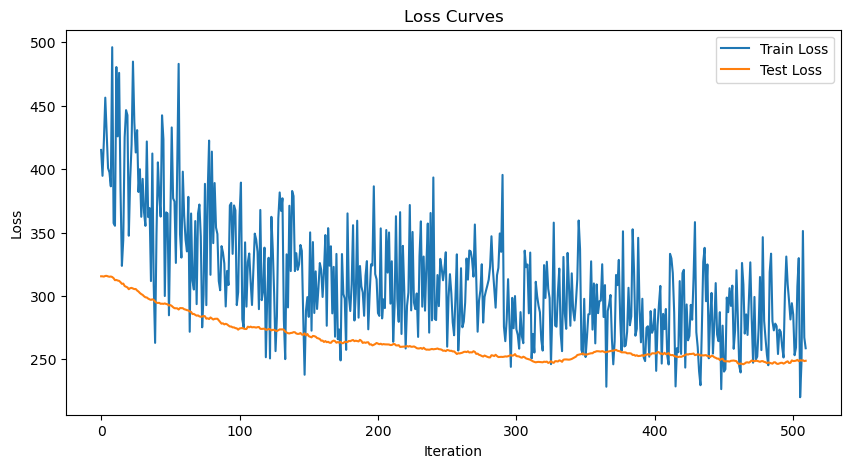

In [255]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [256]:
num_epochs = 5
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(trainloader)

    # Minibatch training loop
    for (data, targets), lengths in train_batch:
        targets = targets.long()

        # forward pass
        net.train()
        
        spk_rec, mem_rec = net(data, lengths)
        mem_rec, _ = pad_packed_sequence(mem_rec)
        mem_rec = mem_rec
        
        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype)
        for step in range(mem_rec.size()[0]):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            (test_data, test_targets), test_lengths = next(iter(testloader))
            test_targets = test_targets.long()

            # Test set forward pass
            test_spk, test_mem = net(test_data, test_lengths)
            test_mem, _ = pad_packed_sequence(test_mem)
            test_mem = test_mem
            

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype)
            for step in range(test_mem.size()[0]):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 300.09
Test Set Loss: 249.04
Train set accuracy for a single minibatch: 12.50%
Test set accuracy for a single minibatch: 25.00%


Epoch 0, Iteration 50
Train Set Loss: 263.79
Test Set Loss: 249.97
Train set accuracy for a single minibatch: 12.50%
Test set accuracy for a single minibatch: 25.00%


Epoch 0, Iteration 100
Train Set Loss: 293.42
Test Set Loss: 249.26
Train set accuracy for a single minibatch: 43.75%
Test set accuracy for a single minibatch: 25.00%


Epoch 0, Iteration 150
Train Set Loss: 232.40
Test Set Loss: 246.47
Train set accuracy for a single minibatch: 12.50%
Test set accuracy for a single minibatch: 37.50%


Epoch 0, Iteration 200
Train Set Loss: 250.98
Test Set Loss: 242.85
Train set accuracy for a single minibatch: 25.00%
Test set accuracy for a single minibatch: 31.25%


Epoch 0, Iteration 250
Train Set Loss: 234.93
Test Set Loss: 242.10
Train set accuracy for a single minibatch: 25.00%
Test set accuracy for a single minibatch

# Test set accuracy after 5 epochs

In [260]:
total = 0
correct = 0

with torch.no_grad():
  net.eval()
  for (test_data, test_targets), test_lengths in testloader:

    # forward pass
    test_spk, test_mem = net(test_data, test_lengths)
    # test_mem, _ = pad_packed_sequence(test_mem)

    output, _ = pad_packed_sequence(test_spk)
    output = output.squeeze()
    idx = output.sum(dim=0).argmax(dim=1)
      
    total += test_targets.size(0)
    correct += (idx == test_targets).sum().item()
    

In [261]:
print(f"Total correctly classified test data: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test data: 691/2264
Test Set Accuracy: 30.52%


In [262]:
len(testset)

2264

# confusion matrix

In [263]:
all_preds = []
all_targets = []

with torch.no_grad():
  net.eval()
  for (test_data, test_targets), test_lengths in testloader:

    # forward pass
    test_spk, test_mem = net(test_data, test_lengths)
    # test_mem, _ = pad_packed_sequence(test_mem)

    output, _ = pad_packed_sequence(test_spk)
    output = output.squeeze()
    idx = output.sum(dim=0).argmax(dim=1)
      
    all_preds.extend(idx.cpu().numpy())
    all_targets.extend(test_targets.cpu().numpy())


In [264]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Create the confusion matrix
conf_matrix = confusion_matrix(all_targets, all_preds)

print(conf_matrix)


[[  1   1   1   0   5   0   6   0   4   0  12   0   0   0   1   0   0  72
    0   0]
 [  1   0   0   5   9  17   0   0   0  29   3   0   0  10   0   0   0  14
    4  16]
 [  0   0  39   2   0   0  31   0   1   0  22   0   0   0   0   0   0   3
    1   6]
 [  0   0   8  24   7   0   2   0   3   2  29   0   0   0   0   0   0  23
    1   3]
 [  0   0   0   0  90  16   0   0   0   0   0   0   0   0   0   0   0   0
   10   0]
 [  0   0   0   0   1  11   0   0   0   1   0   1   0   4   0   0   0   0
   92   0]
 [  0   0   0   0   0   0  69   0   0   0   0   0   0   0   0   0  34   0
    6   0]
 [  0   0   0   0   3   5  57   0   0   0   0   0   0   7   0   0   0   0
   37   0]
 [  0   0   2   0   0   0   4   0 100   0   1   1   0   0   1   0   1   0
    4   0]
 [  0   0   0   0   0   5   0   0   0  28   0   1   0   3   0   0   0   2
   63   1]
 [  3   5   1  22   3   0   0   0   1   2  32   0   0   0   1   0   0  52
    0   0]
 [  0   0   0   0   0   1   4   0   0   1   0   3   0   0   0   0

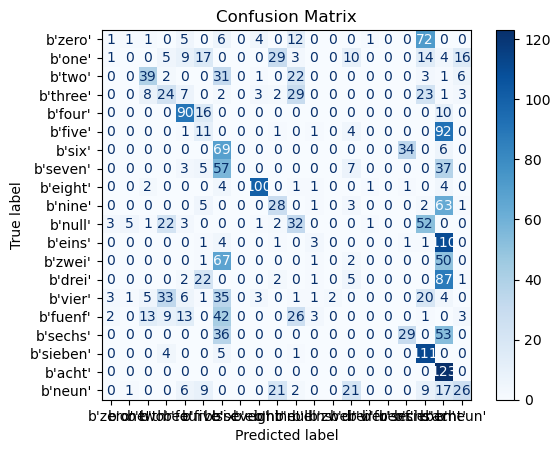

In [266]:
import matplotlib.pyplot as plt

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()


## 5 Test and improve the trained SNN

***Optional task:***

Test and improve the accuracy of your SNN classifier. How high accuracy can you achieve? How close to the SHD leader board is your result? Can you benefit from spiking CNNs, LSTMSs, ...?


In [ ]:
testset = tonic.datasets.SHD(save_to='./data', train=False)

cached_testset = DiskCachedDataset(testset, transform=...

testloader = DataLoader(cached_testset, ...

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-21-2f75bd033652>, line 3)

## References

The Heidelberg Spiking Data Sets for the Systematic Evaluation of Spiking Neural Networks;
[https://doi.org/10.1109/TNNLS.2020.3044364](https://doi.org/10.1109/TNNLS.2020.3044364).

Surrogate Gradient Learning in Spiking Neural Networks: Bringing the Power of Gradient-Based Optimization to Spiking Neural Networks; [https://doi.org/10.1109/MSP.2019.2931595](https://doi.org/10.1109/MSP.2019.2931595).

Training Spiking Neural Networks Using Lessons From Deep Learning; [https://doi.org/10.1109/JPROC.2023.3308088](https://doi.org/10.1109/JPROC.2023.3308088).